# Introdução à Banco de Dados | Trabalho Prático III
Abel Severo Rocha, Ana Carla Fernandes, Natasha Caxias

Prof. Dr. Altigran Soares da Silva

## Parte I
Verificação dos parâmetros do hardware e do software utilizado e familiarização com o ambiente do PostgreSQL.

### Tarefa 1 - Identificação do Sistema

In [119]:
! pip install pandas tabulate

6119.40s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)


In [120]:
import platform
import os
import shutil
import subprocess
import datetime
import psycopg2
import pandas as pd
from tabulate import tabulate
from psycopg2.extras import RealDictCursor
from tpch_pgsql import main as tpch_pgsql
from tpch4pgsql import postgresqldb as pgdb, result as r

In [121]:
def mostrarSoInfo():
    
    soInfo = platform.freedesktop_os_release()
    print("\n--------- Sistema Operacional (SO) ---------\n")
    print("Sistema Operacional ", platform.system())
    print("Versão              ", soInfo["VERSION"])
    print("Release (kernel)    ", platform.release())
    print("Arquitetura         ", platform.machine())
    print("Distribuição        ", soInfo["NAME"])


In [122]:
def mostrarHardwareInfo():

    cpuInfo = {}
    with open("/proc/cpuinfo") as f:
        for line in f:
            if ":" in line:
                k, v = line.split(":", 1)
                cpuInfo[k.strip()] = v.strip()
    
    ramInfo = {}
    with open("/proc/meminfo") as f:
        for line in f:
            k, v = line.split(":", 1)
            ramInfo[k] = v.strip()

    print("\n------------- Sobre o Hardware -------------\n")
    print("Processador:")
    print("  • Modelo          ", cpuInfo["model name"])
    print("  • CPUs lógicas    ", os.cpu_count())
    print("  • Clock base      ", cpuInfo["cpu MHz"], "MHz")

    print("\nCache:")
    with open("/sys/devices/system/cpu/cpu0/cache/index0/size") as f:
        print("  • L1d             ", f.read().strip()[:-1]+" kB")
    with open("/sys/devices/system/cpu/cpu0/cache/index1/size") as f:
        print("  • L1i             ", f.read().strip()[:-1]+" kB")
    with open("/sys/devices/system/cpu/cpu0/cache/index2/size") as f:
        print("  • L2              ", f.read().strip()[:-1]+" kB")
    with open("/sys/devices/system/cpu/cpu0/cache/index3/size") as f:
        print("  • L3              ", f.read().strip()[:-1]+" kB")

    print("\nMemória RAM:")
    print("  • Total           ", ramInfo["MemTotal"])
    print("  • Livre           ", ramInfo["MemFree"])
    print("  • Disponível      ", ramInfo["MemAvailable"])

    total, usado, livre = shutil.disk_usage("/")
    print("\nDisco:")
    print(f"  • Total            {total/1024**3:.2f} GB")
    print(f"  • Usado            {usado/1024**3:.2f} GB")
    print(f"  • Livre            {livre/1024**3:.2f} GB")


In [123]:
mostrarSoInfo()
mostrarHardwareInfo()


--------- Sistema Operacional (SO) ---------

Sistema Operacional  Linux
Versão               22.04.5 LTS (Jammy Jellyfish)
Release (kernel)     6.8.0-87-generic
Arquitetura          x86_64
Distribuição         Ubuntu

------------- Sobre o Hardware -------------

Processador:
  • Modelo           Intel(R) Core(TM) i7-5557U CPU @ 3.10GHz
  • CPUs lógicas     4
  • Clock base       3391.881 MHz

Cache:
  • L1d              32 kB
  • L1i              32 kB
  • L2               256 kB
  • L3               4096 kB

Memória RAM:
  • Total            16260576 kB
  • Livre            1340916 kB
  • Disponível       10762996 kB

Disco:
  • Total            108.98 GB
  • Usado            68.50 GB
  • Livre            34.90 GB


### Tarefa 2 - Verificação de parâmetros de armazenamento

In [124]:
# Permite que os acessos de hdparm sejam feitos sem sudo
# sudo visudo
# seu_usuario ALL=(ALL) NOPASSWD: /sbin/hdparm

In [125]:
BASE = "/sys/block"

def run(cmd):
    return subprocess.check_output(cmd, capture_output=True, text=True).strip()

def getDispositivo():
    for dev in os.listdir(BASE):
        if dev.startswith(("loop", "ram", "dm-")): # ignora
            continue
        return dev # encontra dispositivo
    return None

def ehHD(dispositivo):
    rotational_path = os.path.join(BASE, dispositivo, "queue/rotational")
    
    if os.path.exists(rotational_path):
        with open(rotational_path) as f:
            return f.read().strip() == "1"
    return False

def blocos(dispositivo):
    cmd = f"cat /sys/block/{dispositivo}/queue/logical_block_size"
    print("Blocos Lógicos:", run(cmd.split()))

    cmd = f"cat /sys/block/sdX/queue/physical_b"
    print("Blcocos Físicos: ", run(cmd.split()))

def info(dispositivo):
    cmd = f"sudo hdparm -I /dev/{dispositivo}"
    print(run(cmd.split()))

def stat(dispositivo):
    cmd = f"stat -f /dev/{dispositivo}"
    print("Parâmetros do SO para o disco:\n")
    print(run(cmd.split()))

def mostrarDiscoInfo():
    disp = getDispositivo()
    print("Tipos de dispositivo:", "HD" if ehHD(disp) else "SSD")
    print("Modelo", run(["cat", f"/sys/block/{disp}/device/model"]))
    #info(disp)
    stat(disp)
    blocos(disp)

In [126]:
disp = getDispositivo()
print(disp)
if ehHD(disp):
    mostrarDiscoInfo()
else:
    print("Dispositivo de armazenamento é um SSD.")

sdb
Dispositivo de armazenamento é um SSD.


### Tarefa 3 – Geração de um BD para testes


Necessário dar permissão de escrita para a pasta _tpch4pgsql_:

``chmod -R u+rwX,g+rwX,o+rX .``

#### Preparar
A fase de preparação compila o TPC-H dbgen e querygen e cria os arquivos de carga e atualização (atualização/exclusão).

In [127]:
import os
os.getcwd()


'/home/desktoop2/repos/Banco-de-Dados-2025-2/Trabalho 3/tpch4pgsql'

In [128]:
tpch_pgsql(phase="prepare")

make: Nothing to be done for 'all'.
built dbgen from source


TPC-H Population Generator (Version 2.14.0)
Copyright Transaction Processing Performance Council 1994 - 2010
Generating data for suppliers table
Preloading text ...                                                                                                                                                                                                                                                                                                              1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

generated data for the load phase


TPC-H Population Generator (Version 2.14.0)
Copyright Transaction Processing Performance Council 1994 - 2010
Generating update pair #1 for orders/lineitem tables
Preloading text ...                                                                                                                                                                                                                                                                                                              1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

generated data for the update phase
generated data for the delete phase
created data files in ./data
created query files in ./query_root


#### Carregamento

A fase de carregamento (load) limpa o banco de dados (se necessário), carrega as tabelas no banco de dados e cria índices para consultas. Os resultados desta fase consistem nas seguintes métricas:

* Tempo de criação do esquema
* Tempo de carregamento dos dados
* Tempo de criação de restrições de chave estrangeira e índices

In [ ]:
tpch_pgsql(phase="load")

#### Consultas

Nessa fase, as consultas serão analizadas com o comando ``EXPLAIN ANALYZE``, evidenciando:

* Tempo de execução do planejamento;
* Tempo de execução do _exlpain_;
* Algoritmos utilizados.

Em seguida, as consultas serão executas, exibindo as seguintes informações:

* Até 10 linhas do resultado da consulta;
* Total de linhas encontradas;
* Tempo de execução.

In [ ]:
class PGDBWithResults(pgdb.PGDB):

    def __init__(self, host, port, database, user, password):
        # Chamar o construtor da classe pai corretamente
        self.conn = psycopg2.connect(
                    host=host,
                    port=port,
                    dbname=database,
                    user=user,
                    password=password
                ) 
        if hasattr(self, 'conn') and self.conn:
            print("Conexão estabelecida com sucesso!")
        else:
            print("Atenção: Conexão não estabelecida")
    
    def executeQueryFromFileWithResults(self, filepath):
        """Executa query de arquivo e retorna resultados"""
        try:
            # Verificar se a conexão existe
            if not hasattr(self, 'conn') or not self.conn:
                return {'error': 'Conexão não disponível'}
            
            with open(filepath, 'r') as f:
                query = f.read()
            
            # Usar cursor que retorna dicionários
            with self.conn.cursor(cursor_factory=RealDictCursor) as cursor:
                cursor.execute(query)
                
                if cursor.description:  # Se é uma query SELECT
                    results = cursor.fetchall()
                    columns = [desc[0] for desc in cursor.description]
                    return {
                        'columns': columns,
                        'data': results,
                        'rowcount': cursor.rowcount
                    }
                else:  # Para INSERT, UPDATE, DELETE
                    return {
                        'rowcount': cursor.rowcount,
                        'message': f"Query executada: {cursor.rowcount} linhas afetadas"
                    }
                    
        except Exception as e:
            return {'error': str(e)}
        
    def executeQuery(self, query_string):
        """Executa uma query diretamente a partir de string"""
        try:
            if not self.conn:
                return {'error': 'Conexão não disponível'}
            
            with self.conn.cursor(cursor_factory=RealDictCursor) as cursor:
                cursor.execute(query_string)
                
                if cursor.description:  # Se é uma query SELECT
                    results = cursor.fetchall()
                    columns = [desc[0] for desc in cursor.description]
                    return {
                        'columns': columns,
                        'data': results,
                        'rowcount': cursor.rowcount
                    }
                else:  # Para INSERT, UPDATE, DELETE
                    self.conn.commit()
                    return {
                        'rowcount': cursor.rowcount,
                        'message': f"Query executada: {cursor.rowcount} linhas afetadas"
                    }
                    
        except Exception as e:
            return {'error': str(e)}

In [ ]:
host = "localhost"
port = 5432
user = "postgres"
password = "test123"
database = "tpch"
filepath = "query_root/perf_query_gen/"

conn = PGDBWithResults(host, port, database, user, password)

# Definir algoritmos de junção e varredura comuns no PostgreSQL
algoritmos_juncao = ['Nested Loop', 'Hash Join', 'Merge Join']
algoritmos_varredura = ['Seq Scan', 'Index Scan', 'Index Only Scan', 'Bitmap Heap Scan', 'Bitmap Index Scan']
algoritmos_ordenacao = ['Sort', 'Incremental Sort']
algoritmos_agregacao = ['HashAggregate', 'GroupAggregate']

for i in [1, 3, 5, 6, 7, 9, 10, 12]:
    print(f"\n{'=' * 120}")
    print(f"EXPLAIN ANALYZE - QUERY {i}")
    print(f"{'=' * 120}")
    
    # Ler a query original
    with open(filepath + f"{i}.sql", 'r') as f:
        original_query = f.read()
    
    # Adicionar EXPLAIN ANALYZE
    explain_query = "EXPLAIN ANALYZE " + original_query
    
    start_time = datetime.datetime.now()
    result = conn.executeQuery(explain_query)
    end_time = datetime.datetime.now()
    execution_time = end_time - start_time
    
    if 'error' in result:
        print(f"Erro no EXPLAIN ANALYZE {i}: {result['error']}")
    elif 'data' in result:
        print(f"\nTempo de execução do EXPLAIN: {execution_time}")
        
        # Coletar algoritmos utilizados
        algoritmos_encontrados = {
            'juncao': [],
            'varredura': [],
            'ordenacao': [],
            'agregacao': [],
            'outros': []
        }
        
        print(f"\nPLANO DE EXECUÇÃO (EXPLAIN ANALYZE):")
        for idx, row in enumerate(result['data']):
            plan_line = list(row.values())[0] if row else ""
            print(f"{plan_line}")
            
            # Identificar algoritmos na linha do plano
            for algoritmo in algoritmos_juncao:
                if algoritmo in plan_line:
                    if algoritmo not in algoritmos_encontrados['juncao']:
                        algoritmos_encontrados['juncao'].append(algoritmo)
            
            for algoritmo in algoritmos_varredura:
                if algoritmo in plan_line:
                    if algoritmo not in algoritmos_encontrados['varredura']:
                        algoritmos_encontrados['varredura'].append(algoritmo)
            
            for algoritmo in algoritmos_ordenacao:
                if algoritmo in plan_line:
                    if algoritmo not in algoritmos_encontrados['ordenacao']:
                        algoritmos_encontrados['ordenacao'].append(algoritmo)
            
            for algoritmo in algoritmos_agregacao:
                if algoritmo in plan_line:
                    if algoritmo not in algoritmos_encontrados['agregacao']:
                        algoritmos_encontrados['agregacao'].append(algoritmo)
        
        # Mostrar resumo dos algoritmos utilizados
        print(f"\n{'─' * 80}")
        print("ALGORITMOS IDENTIFICADOS NO PLANO DE EXECUÇÃO:")
        print(f"{'─' * 80}")
        
        if algoritmos_encontrados['juncao']:
            print(f"Algoritmos de Junção: {', '.join(algoritmos_encontrados['juncao'])}")
        
        if algoritmos_encontrados['varredura']:
            print(f"Algoritmos de Varredura: {', '.join(algoritmos_encontrados['varredura'])}")
        
        if algoritmos_encontrados['ordenacao']:
            print(f"Algoritmos de Ordenação: {', '.join(algoritmos_encontrados['ordenacao'])}")
        
        if algoritmos_encontrados['agregacao']:
            print(f"Algoritmos de Agregação: {', '.join(algoritmos_encontrados['agregacao'])}")
        
        # Verificar se não foram encontrados algoritmos conhecidos
        total_algoritmos = (len(algoritmos_encontrados['juncao']) + 
                          len(algoritmos_encontrados['varredura']) + 
                          len(algoritmos_encontrados['ordenacao']) + 
                          len(algoritmos_encontrados['agregacao']))
        
        if total_algoritmos == 0:
            print("ℹNenhum algoritmo específico identificado (possivelmente plano simples)")
            
    else:
        print(f"{result.get('message', 'Resultado inesperado')}")
        print(f"Tempo: {execution_time}")

Conexão estabelecida com sucesso!

EXPLAIN ANALYZE - QUERY 1

Tempo de execução do EXPLAIN: 0:00:04.966359

PLANO DE EXECUÇÃO (EXPLAIN ANALYZE):
Limit  (cost=346387.38..346388.51 rows=1 width=248) (actual time=3712.093..4911.243 rows=1 loops=1)
  ->  Finalize GroupAggregate  (cost=346387.38..391477.69 rows=40000 width=248) (actual time=3692.576..4891.725 rows=1 loops=1)
        Group Key: l_returnflag, l_linestatus
        ->  Gather Merge  (cost=346387.38..387777.69 rows=80000 width=248) (actual time=3658.597..4891.641 rows=4 loops=1)
              Workers Planned: 2
              Workers Launched: 2
              ->  Partial GroupAggregate  (cost=345387.36..377543.68 rows=40000 width=248) (actual time=3494.124..4280.341 rows=3 loops=3)
                    Group Key: l_returnflag, l_linestatus
                    ->  Sort  (cost=345387.36..347471.11 rows=833502 width=144) (actual time=2556.116..2879.068 rows=1124052 loops=3)
                          Sort Key: l_returnflag, l_linestat

## Parte II
Análise do comportamento dos índices das tabelas do SGBD através do exame das tabelas de estatísticas para consultas SQL.

## Parte IV

O objetivo desta parte do trabalho é experimentar estratégias para utilização de transações e níveis de isolamento em SGBDs relacionais. As tarefas envolvem uma simulação de um sistema de reservas de passagem áreas. 


In [1]:
import psycopg2
import time
import random
import threading

DB_CONFIG = {
    "dbname": "tpch",
    "user": "postgres",
    "password": "test123",
    "host": "localhost",
    "port": 5432
}

def reset_db():
    conn = psycopg2.connect(**DB_CONFIG)
    cur = conn.cursor()

    cur.execute("DROP TABLE IF EXISTS assentos;")
    cur.execute("""
        CREATE TABLE assentos(
            num_voo INT PRIMARY KEY,
            disp BOOLEAN
        );
    """)

    # 200 assentos inicialmente livres
    cur.executemany("INSERT INTO assentos VALUES (%s, true);", [(i,) for i in range(1, 201)])

    conn.commit()
    cur.close()
    conn.close()

reset_db()
print("Tabela assentos pronta.")


Tabela assentos pronta.


### Tarefa 17 – Código das Versões A e B

Versão A - Uma única transação

In [ ]:
def reserva_versaoA(isolation_level):

    conn = psycopg2.connect(**DB_CONFIG)
    conn.set_session(isolation_level=isolation_level)
    cur = conn.cursor()

    tentativas = 0

    while True:
        tentativas += 1
        try:
            # Passo 1 — escolher 1 assento livre e BLOQUEAR apenas ele
            cur.execute("""
                SELECT num_voo 
                FROM assentos 
                WHERE disp = true 
                ORDER BY random()
                LIMIT 1
                FOR UPDATE;
            """)
            row = cur.fetchone()

            # Nenhum assento livre → fim
            if not row:
                conn.rollback()
                break

            escolhido = row[0]

            # Passo 2 — espera de 1s (cliente escolhendo)
            time.sleep(1)

            # Passo 3 — marcar como ocupado
            cur.execute("""
                UPDATE assentos 
                SET disp = false 
                WHERE num_voo = %s;
            """, (escolhido,))

            conn.commit()
            break  # reserva feita com sucesso

        except psycopg2.errors.SerializationFailure:
            # conflitos serializáveis → tentar de novo
            conn.rollback()
            continue

        except psycopg2.Error as e:
            # erros inesperados devem ser reportados
            conn.rollback()
            print("Erro inesperado na versão A:", e)
            break

    cur.close()
    conn.close()
    return tentativas


Versão b - Duas transações

In [ ]:
def reserva_versaoB(isolation_level):

    tentativas = 0

    while True:
        tentativas += 1

        try:
            # ================================
            # TRANSAÇÃO 1: obter 1 assento livre
            # ================================
            conn1 = psycopg2.connect(**DB_CONFIG)
            conn1.set_session(isolation_level=isolation_level)
            cur1 = conn1.cursor()

            cur1.execute("""
                SELECT num_voo 
                FROM assentos 
                WHERE disp = true 
                ORDER BY random()
                LIMIT 1;
            """)

            row = cur1.fetchone()

            if not row:
                conn1.commit()
                conn1.close()
                break  # nenhum assento disponível

            escolhido = row[0]

            conn1.commit()
            conn1.close()

            # ================================
            # PASSO 2 — escolha do cliente
            # ================================
            time.sleep(1)

            # ================================
            # TRANSAÇÃO 2: tentar reservar
            # ================================
            conn2 = psycopg2.connect(**DB_CONFIG)
            conn2.set_session(isolation_level=isolation_level)
            cur2 = conn2.cursor()

            cur2.execute("""
                UPDATE assentos
                SET disp = false
                WHERE num_voo = %s AND disp = true;
            """, (escolhido,))

            if cur2.rowcount == 1:
                conn2.commit()
                conn2.close()
                break  # reserva concluída
            else:
                conn2.rollback()
                conn2.close()
                continue  # alguém já pegou → tentar novamente

        except psycopg2.errors.SerializationFailure:
            # conflito serializável → repetir tentativa
            continue

        except Exception as e:
            # erro inesperado → reportar e quebrar
            print("Erro inesperado na versão B:", e)
            break

    return tentativas


### Tarefa 18 – Executar experimentos e gerar gráficos

In [4]:
import time
import threading
import matplotlib.pyplot as plt

# k usados no experimento
k_values = [1, 2, 4, 6, 8, 10]

# estrutura para armazenar os tempos de cada experimento
resultados = {
    "A_READ_COMMITTED": [],
    "A_SERIALIZABLE": [],
    "B_READ_COMMITTED": [],
    "B_SERIALIZABLE": []
}

def executar_experimento(k, versao_func, isolation_level, num_clientes=200):
    """
    Executa um experimento com:
    - k threads (agentes de viagem)
    - num_clientes clientes (default = 200)
    - versao_func: reserva_versaoA ou reserva_versaoB
    - isolation_level: 'READ COMMITTED' ou 'SERIALIZABLE'
    
    Cada cliente é atendido por uma chamada a versao_func, que
    retorna o número de tentativas necessárias até conseguir reservar.
    As threads dividem os clientes entre si até completar num_clientes.
    """

    # Começa sempre com a tabela de 200 assentos livres
    reset_db()

    inicio = time.time()
    tentativas_total = []

    # contador compartilhado de clientes atendidos
    contador = {"cliente": 0}
    lock = threading.Lock()

    def worker():
        while True:
            # pegar "um cliente" para esta thread
            with lock:
                if contador["cliente"] >= num_clientes:
                    return  # todos os clientes já foram atendidos
                contador["cliente"] += 1

            # atende um cliente (uma reserva completa)
            tentativas = versao_func(isolation_level)
            tentativas_total.append(tentativas)

    # cria k threads/agentes
    threads = [threading.Thread(target=worker) for _ in range(k)]

    # inicia e aguarda todas
    for t in threads:
        t.start()
    for t in threads:
        t.join()

    tempo_total = time.time() - inicio
    return tempo_total, tentativas_total


/home/desktoop2/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Executar Experimentos

In [5]:
for k in k_values:

    # Versão A - Read Committed
    t, tent = executar_experimento(k, reserva_versaoA, "READ COMMITTED")
    resultados["A_READ_COMMITTED"].append(t)

    # Versão A - Serializable
    t, tent = executar_experimento(k, reserva_versaoA, "SERIALIZABLE")
    resultados["A_SERIALIZABLE"].append(t)

    # Versão B - Read Committed
    t, tent = executar_experimento(k, reserva_versaoB, "READ COMMITTED")
    resultados["B_READ_COMMITTED"].append(t)

    # Versão B - Serializable
    t, tent = executar_experimento(k, reserva_versaoB, "SERIALIZABLE")
    resultados["B_SERIALIZABLE"].append(t)


Erro inesperado na versão A: deadlock detected
DETAIL:  Process 26560 waits for ShareLock on transaction 6733; blocked by process 26559.
Process 26559 waits for ShareLock on transaction 6735; blocked by process 26560.
HINT:  See server log for query details.
CONTEXT:  while locking tuple (1,100) in relation "assentos"

Erro inesperado na versão A: deadlock detected
DETAIL:  Process 28237 waits for ShareLock on transaction 8895; blocked by process 28240.
Process 28240 waits for ShareLock on transaction 8896; blocked by process 28237.
HINT:  See server log for query details.
CONTEXT:  while locking tuple (1,92) in relation "assentos"



Gerar Gráficos

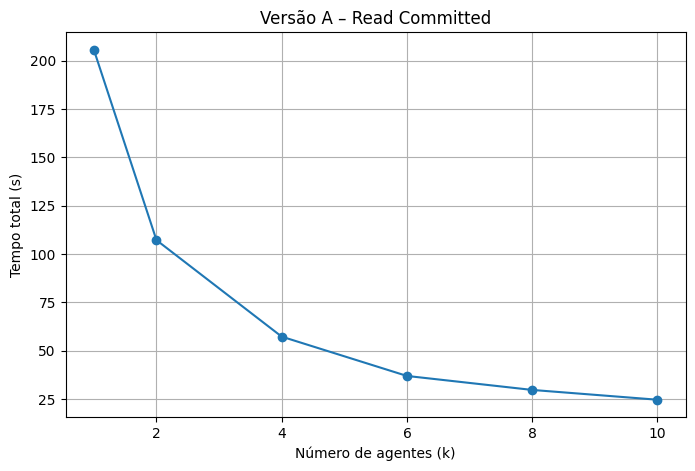

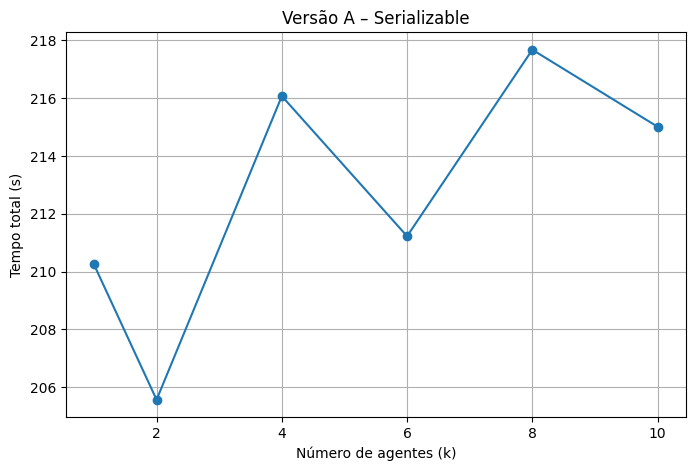

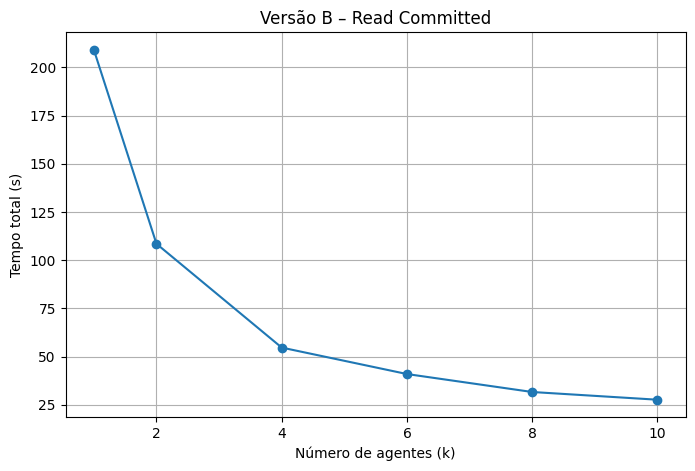

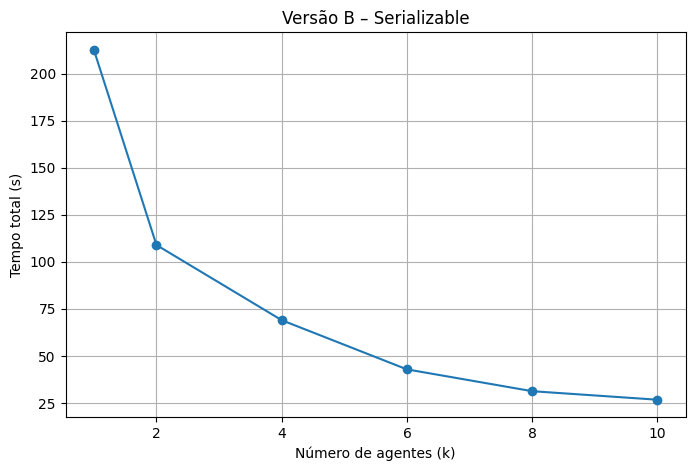

In [6]:
def gerar_grafico(nome, valores, titulo):
    plt.figure(figsize=(8,5))
    plt.plot(k_values, valores, marker='o')
    plt.xlabel("Número de agentes (k)")
    plt.ylabel("Tempo total (s)")
    plt.title(titulo)
    plt.grid(True)
    plt.show()


gerar_grafico(
    "A_READ_COMMITTED",
    resultados["A_READ_COMMITTED"],
    "Versão A – Read Committed"
)

gerar_grafico(
    "A_SERIALIZABLE",
    resultados["A_SERIALIZABLE"],
    "Versão A – Serializable"
)

gerar_grafico(
    "B_READ_COMMITTED",
    resultados["B_READ_COMMITTED"],
    "Versão B – Read Committed"
)

gerar_grafico(
    "B_SERIALIZABLE",
    resultados["B_SERIALIZABLE"],
    "Versão B – Serializable"
)


### Tarefa 19 — Tabela de tentativas

In [7]:
import pandas as pd
import numpy as np

# armazenar as estatísticas 
estatisticas_tentativas = []

def coletar_tentativas(k, versao, isolamento, func_reserva):
    """
    Executa um experimento e retorna min, max e média de tentativas por cliente
    """
    _, tentativas = executar_experimento(k, func_reserva, isolamento)

    tentativas = np.array(tentativas)

    return {
        "k": k,
        "Versão": versao,
        "Isolamento": isolamento,
        "Min": tentativas.min(),
        "Max": tentativas.max(),
        "Média": tentativas.mean()
    }


#  Executar experimentos

for k in k_values:

    # --- Versão A ---
    estatisticas_tentativas.append(
        coletar_tentativas(k, "A", "READ COMMITTED", reserva_versaoA)
    )

    estatisticas_tentativas.append(
        coletar_tentativas(k, "A", "SERIALIZABLE", reserva_versaoA)
    )

    # --- Versão B ---
    estatisticas_tentativas.append(
        coletar_tentativas(k, "B", "READ COMMITTED", reserva_versaoB)
    )

    estatisticas_tentativas.append(
        coletar_tentativas(k, "B", "SERIALIZABLE", reserva_versaoB)
    )


# Criar DataFrame final
df_tentativas = pd.DataFrame(estatisticas_tentativas)

# Ordenar 
df_tentativas = df_tentativas.sort_values(by=["Versão", "Isolamento", "k"])

df_tentativas


,k,Versão,Isolamento,Min,Max,Média
0,1,A,READ COMMITTED,1,1,1.000
4,2,A,READ COMMITTED,1,1,1.000
8,4,A,READ COMMITTED,1,1,1.000
12,6,A,READ COMMITTED,1,1,1.000
16,8,A,READ COMMITTED,1,1,1.000
20,10,A,READ COMMITTED,1,1,1.000
1,1,A,SERIALIZABLE,1,1,1.000
5,2,A,SERIALIZABLE,1,47,2.025
9,4,A,SERIALIZABLE,1,72,4.845
13,6,A,SERIALIZABLE,1,102,6.010


### Tarefa 20 - Análise dos Resultados




1. Versão A — Read Committed

Na versão A com Read Committed, todos os clientes concluíram a reserva sempre na primeira tentativa.

(Min = Max = Média = 1)

Isso ocorre porque:

- A leitura, a espera de 1 segundo e a escrita são executadas dentro de uma única transação.

- No nível Read Committed, a leitura não é bloqueada e o SGBD não precisa garantir serialização global.

- Conflitos reais só acontecem na escrita, e a chance de dois agentes reservarem o mesmo assento simultaneamente é baixa.

*Conclusão*: desempenho estável, sem retrabalho e tempos compatíveis com o aumento de k.


2. Versão A — Serializable

Este foi o cenário mais custoso da simulação. O número de tentativas aumentou significativamente conforme k cresceu, chegando a até 8 retries.

Motivos:

- O nível Serializable exige que a transação inteira seja equivalente a uma execução isolada.

- A versão A mantém a transação aberta durante o tempo de espera de 1 segundo, aumentando a janela crítica.

- Vários agentes leem o mesmo estado dos assentos e tentam reservar posições semelhantes.

- O PostgreSQL detecta conflitos de serialização (como phantom reads e write-write conflicts) e aborta transações, obrigando novas tentativas.

*Conclusão:* alta contenção, muitos abortos de transação e pior desempenho entre todas as combinações.

3. Versão B — Read Committed

A versão B apresentou apenas uma tentativa por cliente em todos os valores de k.

Isso acontece porque:

- A leitura e a escrita acontecem em transações separadas, ambas muito curtas.

- O tempo de espera de 1 segundo ocorre fora de qualquer transação, reduzindo drasticamente a chance de conflito.

- A escrita é rápida o suficiente para não gerar bloqueios significativos.

*Conclusão:* excelente desempenho e nenhuma tentativa extra, mesmo com alta concorrência.

4. Versão B — Serializable

Mesmo sob Serializable, a versão B manteve Min = Max = Média = 1.
Ou seja, a serialização não gerou overhead significativo.

Razões:

- Como a transação de escrita é extremamente curta, as chances de conflito são mínimas.

- A separação entre leitura e escrita impede phantoms e reduz o risco de abortos.

*Conclusão:* comportamento extremamente eficiente, mostrando que a versão B é robusta mesmo no nível de isolamento mais forte.